# 背景概述

$\quad$你喜欢吃披萨吗😍? 不管你喜欢与否, 都欢迎完成本次上机作业! 我们将构建一个基于卷积网络的二元分类器, 用于识别给定的一张图片是否是披萨的照片.

$\quad$请先运行下述两个代码块, 完成`ray`库的安装.

In [1]:
!pip install -U ipywidgets
!pip install -U "ray[data,train,tune,serve]"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import ray

$\quad$如果希望前期模型训练和数据集拆分的结果具有**可复现性**(reproducibility), 请运行下述的代码块, 给随机算法设置好随机数种子.

In [3]:
import torch

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()

# 数据清洗与可视化

$\quad$我们将使用的数据集为`pizza_or_not`, 包含两个子目录. 子目录`pizza`存有983张披萨(阳性)的照片, 子目录`not_pizza`存有983张其他种类食物(阴性)的照片. 每张照片尺寸不一, 但均为彩照, 即含有三个色彩通道(采用[YUV色彩空间](https://dexonsystems.com/blog/rgb-yuv-color-spaces)). 由于文件的结构与信息组织方式相对复杂, 我们定义一个继承自[`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)类的子类, 用于定义从指定文件中读取输入`X`和标签`y_true`的方式.

$\quad$**任务1**: 完成数据集子类`PizzaOrNotDataset`的编写, 你需要依据已有的方法和属性, 实现如下两个方法:
- `__len__(self)`方法, 返回数据集的总长度(总样本数). 这是一个magic method, 在调用函数`len(...)`时使用.
- `__getitem__(self, idx)`方法, 根据给定索引值`idx`返回二元元组`(X, y_true)`, 前者为输入, 后者为标签, **都需要设置为`torch.tensor`格式**. 这是一个magic method, 在调用索引号`[...]`时使用. 只需要实现**索引**(indexing)即可, 无需支持**切片**(slicing)功能.
  - 要求: 索引值处于区间`[0, 983)`内时返回阳性样本的对应文件, 处于区间`[983, 1966)`时返回阴性样本的对应文件, 序号以Python内置库函数[`os.listdir()`](https://docs.python.org/3/library/os.html#os.listdir)排出的顺序给定.

初始化方法中涉及的参数解释如下:
- `root_dir`为根目录, 在本例中即为`pizza_or_not`数据集的存储路径.
- `transform`定义了图像数据的变换. 如果该参数为空(`None`), 则`__getitem__()`方法将给出的输入`X`是一个[`PIL.Image.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image)对象; 如果不为空, 则`X`就是存储于设备`self.device`上的一个`tensor`对象.

### 提示
- 类属性的访问需要加前缀`self.`, 例如`self.device`、`self.transform`等.
- 图片文件的读入可用[`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open)函数完成. 读入后, 你所得到的`PIL.Image.Image`对象可由[`torchvision.transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor)方法转换成`torch.tensor`格式.
- 本次作业建议大家在免费的`c2_m4_cpu`机器上调试完代码后, 利用GPU资源完成正式的超参数优化与模型训练(重新连接机器后, 点击restart kernel and run all cells按钮). 作业内测时使用的GPU设备是`c12_m46_1 * NVIDIA GPU B`, 效率约有4倍的提升(~20s / epoch, 预计从头运行notebook的总花费约45min、5.25元).
  - 数据集的初始化方法含有参数`device`, 所以, 在`__getitem__()`方法中, 你需要保证你返回的`tensor`对象被搬运到了正确的`self.device`属性上. 可以利用[`tensor.to()`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to)方法.
  - 模型在每次完成创建后也应当搬运到`device`上, 稍后详述.
  - 课程预算有限, 请确保你的代码不需要大修后再连接GPU资源, 并谨慎使用.
- 如果想在`device`上原位构造新的`tensor`对象, 请使用小写的t, 即`torch.tensor(..., device=self.device)`而非`torch.Tensor(..., device=self.device)`, 后者[不支持GPU上直接创建](https://discuss.pytorch.org/t/cannot-construct-tensor-directly-on-gpu-in-torch-1-10-1/153751).

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class PizzaOrNotDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, device="cpu"):
        self.positive_idxs = os.listdir(os.path.join(root_dir, "pizza"))
        self.negative_idxs = os.listdir(os.path.join(root_dir, "not_pizza"))
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
    def __len__(self):
        ### BEGIN YOUR SOLUTION ###
        raise NotImplementedError()
        ### END YOUR SOLUTION ###
    def __getitem__(self, idx: int):
        ### BEGIN YOUR SOLUTION ###
        raise NotImplementedError()
        ### END YOUR SOLUTION ###
    @property
    def n_positive(self):
        return len(self.positive_idxs)
    @property
    def n_negative(self):
        return len(self.negative_idxs)

$\quad$完成任务1后, 请**务必**运行下面的代码块进行检查. 我们定义的图像变换操作流是: (1) 格式转换为tensor(同时, PyTorch会自动将每个像素值作重标度, 除以255); (2) 图片的大小调整为128x128, 即总共16384个像素.

In [ ]:
from torchvision.transforms import Compose, ToTensor, Resize

device = "cuda" if torch.cuda.is_available() else "cpu"
pizza_or_not_dataset = PizzaOrNotDataset(
    root_dir="/bohr/MLInChem-468s/v1/",
    transform=Compose([ToTensor(), Resize((128, 128))]),
    device=device
)
X_demo, y_true_demo = pizza_or_not_dataset[0]
X_demo.shape, y_true_demo

$\quad$检查完成后, 你可以运行下面的代码块, 完成其中部分样本的可视化. Hmmm! 怎么样, 有没有心动的一款😋!

In [ ]:
from typing import List
from matplotlib import pyplot as plt

def visualize_data(samples: List, n_rows: int):
    plt.figure(figsize=(10, 3))
    n_samples = len(samples)
    for i, sample in enumerate(samples):
        img, label = sample
        plt.subplot(n_rows, n_samples // n_rows, i + 1)
        plt.imshow(img.permute((1, 2, 0)).cpu(), interpolation="none")
        plt.title(f"label: {int(label.item())}")
        plt.axis("off")
    plt.show()

visualize_data(samples=[pizza_or_not_dataset[i] for i in (300, 600, 900, 1200, 1500, 1800)], n_rows=2)

# 模型的搭建

$\quad$我们搭建的模型架构如下图所示. 这是一个卷积网络+全连接网络的架构, 其中, 卷积模块`ConvModule`包含两组卷积-最大池化操作, 并且第二次的卷积核有所扩张, 以提取更广域的像素信息. 模型的最终输出由Sigmoid函数激活, 并解释为(二分类问题中的)阳性概率. 图中默认采用3x3卷积核和1024大小的隐藏层, 这两个值将在稍后作为模型超参数进行调整.

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/e3280ab6cfff400c81b1498c88c11640/AaSUBYAtPBRcwapsIaMEDQ.png)

$\quad$以下是卷积模块`ConvModule`的代码实现.

In [ ]:
from torch import nn
from torch.nn import functional as F

class ConvModule(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=kernel_size, dilation=1, padding="same")
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=kernel_size, dilation=3, padding="same")
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, X):
        X = self.pooling1(F.relu(self.conv1(X)))
        X = self.pooling2(F.relu(self.conv2(X)))
        return X

$\quad$**任务2**: 根据已给出的`ConvModule`模块代码以及图示模型架构, 完成模型子类`PizzaOrNotModel`的编写. 你需要实现如下两个方法:
- `__init__(self, kernel_size, num_hiddens)`方法, 根据给定的卷积核大小和隐藏层大小, 以类属性的形式定义必要的组件和层;
- `forward(self, X)`方法, 给出前向传播的输出.

### 提示
- PyTorch建议使用[`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html#torch-sigmoid)接口, 而非[`F.sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html#torch-nn-functional-sigmoid).
- 卷积模块`ConvModule`的输出形状为`(B, C, H, W)`, 分别代表: 批次大小、通道数(上述模型中为16)、高度(上述数据为128)、宽度(上述数据为128). 你需要将后三个维度“压扁”为一维再送入全连接层. 可参考[`tensor.reshape`](https://pytorch.org/docs/stable/generated/torch.Tensor.reshape.html#torch-tensor-reshape)方法.

In [ ]:
class PizzaOrNotModel(nn.Module):
    def __init__(self, kernel_size=3, num_hiddens=1024):
        super().__init__()
        self.conv_module = ConvModule(kernel_size=kernel_size)
        self.fcnn = nn.Linear(16 * 128 * 128, num_hiddens)
        self.activation = nn.Sigmoid()

        ### END YOUR SOLUTION ###
    def forward(self, X):
        X = self.conv_module(X).reshape((X.shape[0], -1))
        X = self.fcnn(X)
        return self.activation(X)

$\quad$完成任务2后, 请**务必**运行下面的代码块进行检查. 注意到`model.to(device)`的作用即是将模型搬运到对应的设备上.

In [ ]:
pizza_or_not_model = PizzaOrNotModel().to(device)
pizza_or_not_model(X_demo.unsqueeze(0))

# 超参数对模型训练的影响: 试验与优化

$\quad$我们下面先定性讨论模型超参数对训练过程的影响, 再利用`ray`进行超参数的网格搜索优化.

## 搭建训练组件

$\quad$**任务3**: 根据以下两个给出的函数`train_model_epoch()`和`evaluate_model()`, 完成函数`train_model`的编写. 输入:
- 训练集`train_subset`与验证集`val_subset`.
- 训练配置字典`config`, 包含关键字`batch_size`、`kernel_size`、`num_hiddens`、`lr`.
- 训练周期数`num_epochs`, 默认值为5.
- 描述设备的字符串`device`, 默认为`cpu`, 如果选择了GPU机器, 则参数值为`cuda`.
- 逻辑变量`log`, 表示是否在训练过程中输出训练记录. 如果为`True`, 要求报告: 训练周期数、特定批次的平均损失函数(详见`train_model_epoch()`函数)、该周期的平均损失函数, 报告信息的格式可以自选.
- 逻辑变量`save`, 表示是否在完成训练后保存模型. 如果为`True`, 要求在notebook同目录下储存训练完成后的模型参数至`PizzaOrNotModel.pt`.

返回四元元组: 每个周期上的 (1) 训练集损失函数; (2) 训练集准确率(accuracy); (3) 验证集损失函数; (4) 验证集准确率. 其中, 要求优化器选择[`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd)(取参数`momentum`为0.5), 损失函数选择[`nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss)且对批次求平均.

### 提示
- 函数`train_model_epoch()`用于单个周期的训练, 输入模型、训练用`DataLoader`对象、优化器`optimizer`、损失函数`criterion`和记录标记`log`, 进行单周期的模型参数优化, 返回该周期在训练集上的平均损失函数.
- 函数`evaluate_model()`用于模型评估, 输入模型、评估用`DataLoader`对象、损失函数`criterion`和分类决策阈值`threshold`, 返回五元元组: 平均损失函数、真阴性样本数`tn`、假阳性样本数`fp`、假阴性样本数`fn`、真阳性样本数`tp`.
- 注意: 模型需要在函数内完成创建, 并以`.to()`方法搬运到正确的计算设备上.
- [Nesterov动量](https://proceedings.mlr.press/v28/sutskever13.html)是一种通过引入历史梯度信息加速SGD优化算法收敛的技巧. 在算法实践中一般推荐`momentum`取初值为0.5.

In [ ]:
def train_model_epoch(model, dataloader, optimizer, criterion, log=True):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    for i, (X, y_true) in enumerate(dataloader):
        optimizer.zero_grad()
        y_prob = model(X)
        loss = criterion(y_prob, y_true)
        loss.backward()
        optimizer.step()
        train_loss += loss
        if log:
            if i % 100 == 0:
                print(f"Batch No. {i}, loss = {loss.item()}")
    return (train_loss / num_batches).item()

In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, threshold: float=0.5):
    model.eval()
    loss, tp, fp, tn, fn = 0, 0, 0, 0, 0
    num_batches = len(dataloader)
    for X, y_true in dataloader:
        y_prob = model(X)
        loss += criterion(y_prob, y_true)
        y_pred = (y_prob > threshold)
        for idx in range(y_true.shape[0]):
            true, pred = int(y_true[idx].item()), int(y_pred[idx].item())
            if (true, pred) == (1, 1):
                tp += 1
            elif (true, pred) == (1, 0):
                fn += 1
            elif (true, pred) == (0, 1):
                fp += 1
            else:
                tn += 1
    return (loss / num_batches).item(), tn, fp, fn, tp

In [ ]:
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(
    train_subset, val_subset, config: Dict, num_epochs: int=5,
    device="cpu", log=True, save=False
) -> Tuple[List[float], List[float], List[float]]:
    ### BEGIN YOUR SOLUTION ###
    raise NotImplementedError()
    ### END YOUR SOLUTION ###

$\quad$完成任务3后, 请**务必**运行下面两个代码块进行检查. 我们将数据集随机拆分为9:1的训练集与测试集, 并做5个周期的训练尝试, 观察对应的损失函数与准确率.

In [ ]:
from torch.utils.data import random_split

config = {
    "kernel_size": 3, "num_hiddens": 1024,
    "batch_size": 8, "lr": 0.01,
}
train_subset, test_subset = random_split(pizza_or_not_dataset, [0.9, 0.1])
train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device=device)

In [ ]:
train_losses, train_accs, val_losses, val_accs

## 超参数数值的试验

$\quad$在正式进行超参数的组合优化之前, 我们先对两个超参数(卷积核、学习率)的意义做更详细的定性讨论. 为此, 我们先定义下述的函数`visualize_learning`, 用于将训练过程中的损失函数与准确率值进行可视化.

In [ ]:
def visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    mode="tune", labels=None
):
    if mode == "tune":
        fig, axes = plt.subplots(2, 2, layout="constrained")
        for label, train_losses in zip(labels, train_losses_collection):
            axes[0][0].plot(train_losses, marker="^", label=label)
        axes[0][0].set_title("Train losses")
        axes[0][0].set_xlabel("Epoch No.")
        axes[0][0].set_ylabel("Loss")
        axes[0][0].legend()
        for label, val_losses in zip(labels, val_losses_collection):
            axes[0][1].plot(val_losses, marker="^", label=label)
        axes[0][1].set_title("Validation losses")
        axes[0][1].set_xlabel("Epoch No.")
        axes[0][1].set_ylabel("Loss")
        axes[0][1].legend()
        for label, train_accs in zip(labels, train_accs_collection):
            axes[1][0].plot(train_accs, marker="^", label=label)
        axes[1][0].set_title("Train accuracies")
        axes[1][0].set_xlabel("Epoch No.")
        axes[1][0].set_ylabel("Accuracy")
        axes[1][0].legend()
        for label, val_accs in zip(labels, val_accs_collection):
            axes[1][1].plot(val_accs, marker="^", label=label)
        axes[1][1].set_title("Validation accuracies")
        axes[1][1].set_xlabel("Epoch No.")
        axes[1][1].set_ylabel("Accuracy")
        axes[1][1].legend()
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(train_losses_collection, label="train")
        ax1.plot(val_losses_collection, label="test")
        ax1.set_title("Losses on train/test dataset")
        ax1.set_xlabel("Epoch No.")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax2.plot(train_accs_collection, label="train")
        ax2.plot(val_accs_collection, label="test")
        ax2.set_title("Accuracies on train/test dataset")
        ax2.set_xlabel("Epoch No.")
        ax2.set_ylabel("Accuracy")
        ax2.legend()

$\quad$**任务4**: 分别讨论下述超参数对模型性能的影响.
- **任务4.1**: 其他条件不变, 取卷积核`kernel_size`分别为1、3、5;
- **任务4.2**: 其他条件不变, 取学习率`lr`分别为0.001、0.01、0.1.

$\quad$运行下述代码块, 观察结果, 在对应答题区解释你关于卷积核的发现.
- 提示: 卷积核大小如何影响空间信息的提取能力、如何影响模型参数的规模?

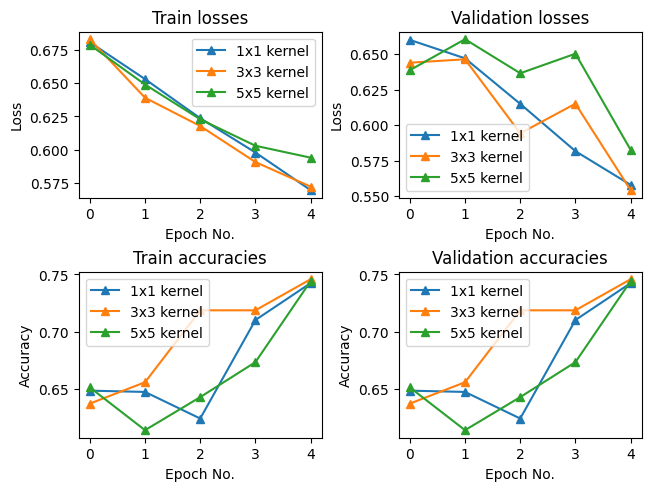

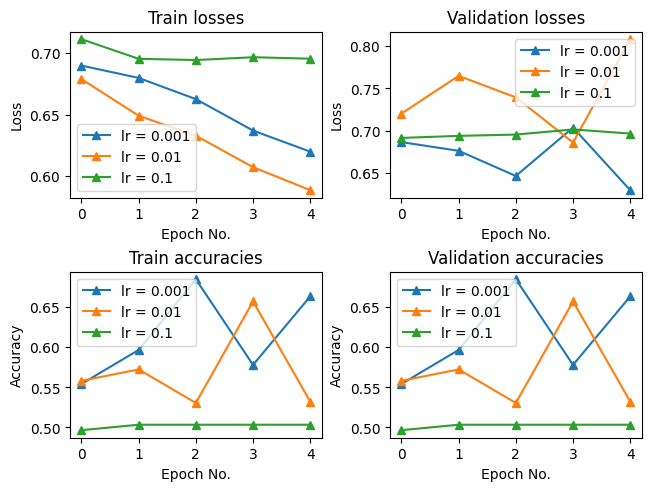

In [ ]:
kernel_size_collection = (1, 3, 5)
labels = []
train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection = [], [], [], []

for kernel_size in kernel_size_collection:
    config["kernel_size"] = kernel_size
    labels.append(f"{kernel_size}x{kernel_size} kernel")
    train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=False, device=device)
    train_losses_collection.append(train_losses)
    train_accs_collection.append(train_accs)
    val_losses_collection.append(val_losses)
    val_accs_collection.append(val_accs)

visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    labels=labels
)

### 任务4.1答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
#
### END YOUR SOLUTION ###

$\quad$运行下述代码块, 观察结果, 在对应答题区解释你关于学习率的发现.
- 提示: 梯度下降的步长过大或过小会导致怎样的后果?

In [ ]:
config["batch_size"] = 8
lr_collection = (10 ** n for n in (-3, -2, -1))
labels = []
train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection = [], [], [], []

for lr in lr_collection:
    config["lr"] = lr
    train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=False, device=device)
    labels.append(f"lr = {lr}")
    train_losses_collection.append(train_losses)
    train_accs_collection.append(train_accs)
    val_losses_collection.append(val_losses)
    val_accs_collection.append(val_accs)

visualize_learning(
    train_losses_collection, train_accs_collection, val_losses_collection, val_accs_collection,
    labels=labels
)

### 任务4.2答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
#
### END YOUR SOLUTION ###

## 超参数的组合优化

$\quad$现在, 我们使用`ray`库完成超参数优化.

$\quad$**任务5**: 完成可训练函数`trainable`的编写, 按照`ray`库的要求, 只接受训练配置字典作为唯一的输入. 要求: 根据已给出的`splits`索引列表, 实现训练集上的5折交叉验证, 并以[`ray.train.report`](https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray-train-report)函数报告平均(最后一个训练周期上的)的平均验证损失`val_loss`与平均验证准确率`val_acc`.

### 提示
- 如果希望具有可复现性, 可以在你的函数开头加上[`train.torch.enable_reproducibility()`](https://docs.ray.io/en/latest/train/user-guides/reproducibility.html#reproducibility).
- 用好前面已经写好的`train_model()`函数.

In [ ]:
from sklearn.model_selection import KFold
from ray import train
import ray.train.torch

n_splits = 5
splits = list(KFold(n_splits=n_splits, shuffle=True, random_state=42).split(train_subset))

def trainable(config):
    ray.train.torch.enable_reproducibility()
    ### BEGIN YOUR SOLUTION ###
    raise NotImplementedError()
    ### END YOUR SOLUTION ###

$\quad$完成任务5后, 请**务必**运行下述代码块, 完成超参数优化的过程. 我们将取10个训练周期, 并进行6组尝试, 以“验证集损失函数值最小”作为超参数的选择标准.
- **注意**: 机器配置`{"cpu": 4, "gpu": 0.3}`是对应`c12_m46_1 * NVIDIA GPU B`机器的, 这将每次同时运行3组超参数配置的尝试(每组尝试对应4 CPU、0.3 GPU). 如果你是在`c2_m4_cpu`上运行, 则应改为`{"cpu": 2, "gpu": 0}`. 如果是在本地机器上运行, 则需要根据具体的机器配置自行决定. 可通过[`ray.cluster_resources()`](https://docs.ray.io/en/latest/ray-core/api/doc/ray.cluster_resources.html#ray-cluster-resources)方法查看你的计算资源.
- 如果受限于计算资源无法完成调参过程, 你可以直接使用前面给出的`config`字典的初值进行后续训练(注意将学习率`lr`调回0.01), 但请增设一个代码块输出`ray.cluster_resources()`的运行结果, 不会因此而影响作业得分.

In [1]:
import ray
from ray import tune

ray.init(num_cpus=10, num_gpus=1)
ray.cluster_resources()

2023-11-17 01:33:08,132	INFO worker.py:1639 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


{'object_store_memory': 1452423168.0,
 'node:127.0.0.1': 1.0,
 'memory': 2904846336.0,
 'GPU': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 10.0}

In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(max_t=10, grace_period=5)

tune_config = tune.TuneConfig(
    metric="val_loss", mode="min",
    scheduler=scheduler,
    num_samples=6,
)

param_space = {
    "lr": tune.loguniform(1e-2, 1e-1),
    "num_hiddens": tune.choice([512, 1024]),
    "kernel_size": tune.choice([3, 5]),
    "batch_size": tune.choice([8, 16, 32])
}

tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(trainable),
        # resources={"cpu": 2, "gpu": 0}
        resources={"cpu": 4, "gpu": 0.3}
    ),
    tune_config=tune_config,
    param_space=param_space
)

results = tuner.fit()

$\quad$优化完成后, 请**务必**运行下述代码块, 获得最优超参数配置.

In [ ]:
best_result = results.get_best_result("val_loss", "min")
best_result.config

# 模型训练与预测

$\quad$最后, 我们以最优超参数配置在全体训练集上训练10个周期, 并将训练好的模型保存, 作新一轮的评估.

$\quad$**任务6**: 运行下述4个代码块, 输出模型的准确率、查准率、查全率. 看一看我们的披萨分类器从众多食物中区分出披萨的能力如何🥳!

In [ ]:
train_losses, train_accs, test_losses, test_accs = train_model(
    train_subset, test_subset, config=best_result.config, num_epochs=10,
    log=True, save=True, device=device
)

In [ ]:
visualize_learning(train_losses, train_accs, test_losses, test_accs, mode="train")

In [ ]:
def report_metrics(tn, fp, fn, tp):
    return {
        "accuracy": (tn + tp) / (tn + fp + fn + tp),
        "precision": tp / (tp + fp),
        "recall": tp / (tp + fn)
    }

In [ ]:
model = PizzaOrNotModel(
    kernel_size=best_result.config["kernel_size"],
    num_hiddens=best_result.config["num_hiddens"],
).to(device)
model.load_state_dict(torch.load("PizzaOrNotModel.pt"))
_, tn, fp, fn, tp = evaluate_model(model, DataLoader(test_subset), criterion=nn.BCELoss())
report_metrics(tn, fp, fn, tp)

In [2]:
import torch
print(torch.__version__)

1.13.1
